In [ ]:
# Check for GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-03dd45d8-0bf6-c3aa-2979-9578816537fe)


In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-02-11 14:38:57--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-02-11 14:38:57 (97.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

In [ ]:
# Download data (same as from Kaggle)
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"

# Unzip data
unzip_data("nlp_getting_started.zip")

--2022-02-11 14:39:00--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.18.128, 142.250.153.128, 142.250.145.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.18.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.004s  

2022-02-11 14:39:00 (147 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [ ]:
# Turn .csv files into pandas DataFrame's
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [ ]:
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [ ]:
# How many samples total?
print(f"Total training samples: {len(train_df)}")
print(f"Total test samples: {len(test_df)}")
print(f"Total samples: {len(train_df) + len(test_df)}")

Total training samples: 7613
Total test samples: 3263
Total samples: 10876


In [ ]:
import random
for i in range(5):
    random_index = random.randint(0, len(train_df))
    target = train_df_shuffled.iloc[random_index][4]
    text = train_df_shuffled.iloc[random_index][3]

    if target==1: print(f'Target: {target} (real disaster)')
    else: print(f'Target: {target} (not real disaster)')
    print(f'Text: {text}\n')
    print('-'*10)

Target: 0 (not real disaster)
Text: If u faved that I hope you fall off a cliff ??

----------
Target: 1 (real disaster)
Text: Families to sue over Legionnaires: More than 40 families affected by the fatal outbreak of Legionnaires' disea... http://t.co/mNsy1QR7bq

----------
Target: 0 (not real disaster)
Text: Fear is the mind killer. Fear is the little-death that brings total obliteration.  Bene Gesserit Litany Against Fear Dune   @atgrannyshouse

----------
Target: 0 (not real disaster)
Text: This bowl got me thinking... Damn I've been blazing for so damn long

----------
Target: 0 (not real disaster)
Text: @petereallen @HuffPostUK @bbc5live How significant do you think the iconic pic of Church (maybe) ruins and less substantial efforts razed?

----------


In [ ]:
from sklearn.model_selection import train_test_split

# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1, # dedicate 10% of samples to validation set
                                                                            random_state=42) # random state for reproducibility

In [ ]:
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [ ]:
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object), array([0, 

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

In [ ]:
text_vectorizer = TextVectorization(max_tokens=None, 
                                    standardize="lower_and_strip_punctuation",
                                    split="whitespace", # how to split tokens
                                    ngrams=None, # create groups of n-words?
                                    output_mode="int", # how to map tokens to numbers
                                    output_sequence_length=None)

In [ ]:
# Find average number of tokens (words) in training Tweets
add = 0
for i in train_sentences:
    add += len(i.split())

print(round(add/len(train_sentences)))

15


In [ ]:
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be (e.g. how many words from a Tweet does our model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [ ]:
text_vectorizer.adapt(train_sentences)

In [ ]:
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [ ]:
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
Watch This Airport Get Swallowed Up By A Sandstorm In Under A Minute http://t.co/NX2d83A4Du      

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[135,  19, 559,  52, 640,  27,  18,   3, 365,   4, 204,   3, 539,
          1,   0]])>

In [ ]:
print(f'Total Number of unique words: {len(text_vectorizer.get_vocabulary())}')
print(f'Top 5 words: {text_vectorizer.get_vocabulary()[:5]}')
print(f'Bottom 5 words: {text_vectorizer.get_vocabulary()[-5:]}')

# [UNK] means unknown tokens

Total Number of unique words: 10000
Top 5 words: ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


* `input_dim` - The size of the vocabulary (e.g. len(text_vectorizer.get_vocabulary()).
* `output_dim` - The size of the output embedding vector, for example, a value of 100 outputs a feature vector of size 100 for each word.
* `embeddings_initializer` - How to initialize the embeddings matrix, default is "uniform" which randomly initalizes embedding matrix with uniform distribution. This can be changed for using pre-learned embeddings.
* `input_length` - Length of sequences being passed to embedding layer.

In [ ]:
from tensorflow.keras.layers import Embedding

embedding = Embedding(input_dim = max_vocab_length,
                      output_dim = 128,
                      input_length=max_length)
embedding

In [ ]:
random_sentence = random.choice(train_sentences)
embed = embedding(text_vectorizer([random_sentence]))
embed

<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.04413476, -0.02742995,  0.01438073, ...,  0.00359119,
          0.02812053,  0.01429893],
        [ 0.00904359, -0.03175982,  0.01532216, ..., -0.04353074,
          0.00595059,  0.01088914],
        [-0.01085898, -0.03183009, -0.00552944, ..., -0.00098033,
         -0.01738129, -0.00996011],
        ...,
        [-0.03679508, -0.00206094, -0.03953186, ..., -0.02849896,
         -0.04198704, -0.01157706],
        [ 0.00427128,  0.00534015,  0.01676762, ..., -0.03331752,
          0.01191074, -0.027657  ],
        [ 0.00427128,  0.00534015,  0.01676762, ..., -0.03331752,
          0.01191074, -0.027657  ]]], dtype=float32)>

In [ ]:
embed[0][0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([ 0.04413476, -0.02742995,  0.01438073, -0.0132053 , -0.03217834,
        0.00459398,  0.04026664, -0.00560812, -0.01884036,  0.0377833 ,
       -0.02549445, -0.01387871,  0.01722951, -0.0024668 ,  0.01022547,
       -0.0209882 ,  0.00379872,  0.01522848, -0.04135386,  0.04470984,
       -0.02357104,  0.04058426, -0.01576095,  0.03343675,  0.03658359,
       -0.04370664,  0.03330121,  0.00308575,  0.00642216, -0.01105243,
        0.04855117, -0.01347792,  0.00211625, -0.02205048,  0.02105104,
       -0.01274583,  0.02993676,  0.03532858, -0.02580037, -0.03103374,
        0.00143558, -0.02294521,  0.03603527, -0.00809835, -0.03986119,
       -0.02703513,  0.04705441,  0.02591387, -0.03775997, -0.01892731,
        0.00344244, -0.02184995,  0.00246428, -0.02710326, -0.04269226,
       -0.02473519,  0.01405403,  0.01322288, -0.01269009,  0.01162867,
       -0.03455862, -0.01781067, -0.04585425,  0.02923438, -0.00687661,
       -0.031829

# Navie Bayes

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [ ]:
model0 = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf', MultinomialNB())
])

model0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
#Evaluate Model
baseline_score = model0.score(val_sentences, val_labels)
print(f'Accuracy: {baseline_score*100:.2f}%')

Accuracy: 79.27%


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [ ]:
# Get baseline results
baseline_preds = model0.predict(val_sentences)
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

# Model 1: A simple dense model


In [ ]:
# Create tensorboard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# Create directory to save TensorBoard logs
SAVE_DIR = "model_logs"

In [ ]:
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string") 
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x) 
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")

In [ ]:
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [ ]:
model_1_history = model_1.fit(train_sentences, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR, 
                                                                     experiment_name="simple_dense_model")])

Saving TensorBoard log files to: model_logs/simple_dense_model/20220211-143905
Epoch 1/5
215/215 [==============================] - 4s 10ms/step - loss: 0.6137 - accuracy: 0.6890 - val_loss: 0.5387 - val_accuracy: 0.7493
Epoch 2/5
215/215 [==============================] - 2s 8ms/step - loss: 0.4436 - accuracy: 0.8174 - val_loss: 0.4692 - val_accuracy: 0.7835
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.3481 - accuracy: 0.8600 - val_loss: 0.4587 - val_accuracy: 0.7927
Epoch 4/5
215/215 [==============================] - 2s 7ms/step - loss: 0.2861 - accuracy: 0.8891 - val_loss: 0.4583 - val_accuracy: 0.7874
Epoch 5/5
215/215 [==============================] - 2s 9ms/step - loss: 0.2393 - accuracy: 0.9132 - val_loss: 0.4772 - val_accuracy: 0.7874


In [ ]:
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 5ms/step - loss: 0.4772 - accuracy: 0.7874


[0.47717031836509705, 0.787401556968689]

In [ ]:
embed_weights = model_1.get_layer("embedding").get_weights()[0]
embed_weights

array([[ 0.02853827, -0.0260789 ,  0.06297103, ...,  0.03872567,
        -0.01814631,  0.05760905],
       [ 0.0028711 ,  0.00335963,  0.02012968, ..., -0.03350375,
         0.0100235 , -0.02505888],
       [ 0.02173254, -0.04088267, -0.01772055, ..., -0.04716168,
        -0.0402599 , -0.00554825],
       ...,
       [ 0.00983038,  0.04085154,  0.02341802, ..., -0.00882455,
        -0.0259087 ,  0.02447147],
       [-0.00730673, -0.06557693,  0.00299426, ..., -0.01428304,
        -0.0519438 ,  0.07767053],
       [ 0.08135352, -0.05834177,  0.03341672, ..., -0.09744699,
        -0.0759193 ,  0.10594667]], dtype=float32)

In [ ]:
# Make predictions on the validation dataset
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs.shape, model_1_pred_probs[:10]

((762, 1), array([[0.35503003],
        [0.8515171 ],
        [0.9976433 ],
        [0.14220041],
        [0.1100833 ],
        [0.94705725],
        [0.9185444 ],
        [0.9932261 ],
        [0.9680076 ],
        [0.3357362 ]], dtype=float32))

In [ ]:
# Round out predictions and reduce to 1-dimensional array
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.74015748031496,
 'f1': 0.7846966492209201,
 'precision': 0.7914920592553047,
 'recall': 0.7874015748031497}

# RNN

In [ ]:
from tensorflow.keras.layers import *

inputs = Input(shape = (1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
x = LSTM(units=64, return_sequences=True)(x)
x = LSTM(64)(x)
x = Dense(64, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

model_2 = tf.keras.Model(inputs, x, name='model_2_LSTM')
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 15, 64)            49408     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                      

In [ ]:
# Compile model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Fit model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "LSTM")])

Saving TensorBoard log files to: model_logs/LSTM/20220211-143928
Epoch 1/5
215/215 [==============================] - 9s 12ms/step - loss: 0.2180 - accuracy: 0.9204 - val_loss: 0.5845 - val_accuracy: 0.7887
Epoch 2/5
215/215 [==============================] - 2s 8ms/step - loss: 0.1601 - accuracy: 0.9407 - val_loss: 0.8104 - val_accuracy: 0.7848
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.1303 - accuracy: 0.9520 - val_loss: 0.7918 - val_accuracy: 0.7808
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.1067 - accuracy: 0.9590 - val_loss: 0.8527 - val_accuracy: 0.7769
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0799 - accuracy: 0.9670 - val_loss: 1.0383 - val_accuracy: 0.7782


In [ ]:
# Make predictions on the validation dataset
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs.shape, model_2_pred_probs[:10]

((762, 1), array([[1.7516777e-02],
        [7.5763291e-01],
        [9.9997830e-01],
        [1.9992903e-01],
        [4.7571193e-05],
        [9.9993503e-01],
        [9.5542538e-01],
        [9.9998951e-01],
        [9.9998426e-01],
        [4.8760432e-01]], dtype=float32))

In [ ]:
# Round out predictions and reduce to 1-dimensional array
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Calculate LSTM model results
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 77.82152230971128,
 'f1': 0.7770477406701836,
 'precision': 0.7785021759388857,
 'recall': 0.7782152230971129}

# GRU Layer


In [ ]:
from tensorflow.keras.layers import *

inputs = Input(shape = (1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
x = GRU(units=64, return_sequences=True)(x)
x = GlobalAveragePooling1D()(x)
x = Dense(64, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

model_3 = tf.keras.Model(inputs, x, name='model_3_GRU')
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 15, 64)            37248     
                                                                 
 global_average_pooling1d_1   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_3 (Dense)             (None, 64)                

In [ ]:
# Compile model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "GRU")])

Saving TensorBoard log files to: model_logs/GRU/20220211-143953
Epoch 1/5
215/215 [==============================] - 4s 9ms/step - loss: 0.1607 - accuracy: 0.9514 - val_loss: 0.7215 - val_accuracy: 0.7795
Epoch 2/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0898 - accuracy: 0.9664 - val_loss: 0.8525 - val_accuracy: 0.7743
Epoch 3/5
215/215 [==============================] - 1s 7ms/step - loss: 0.0668 - accuracy: 0.9730 - val_loss: 1.3237 - val_accuracy: 0.7743
Epoch 4/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0554 - accuracy: 0.9747 - val_loss: 1.3758 - val_accuracy: 0.7769
Epoch 5/5
215/215 [==============================] - 1s 7ms/step - loss: 0.0484 - accuracy: 0.9771 - val_loss: 1.6882 - val_accuracy: 0.7769


In [ ]:
# Make predictions on the validation dataset
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs.shape, model_3_pred_probs[:10]

((762, 1), array([[4.8460811e-02],
        [9.8656487e-01],
        [1.0000000e+00],
        [3.1568322e-01],
        [5.6610259e-07],
        [1.0000000e+00],
        [9.9996197e-01],
        [1.0000000e+00],
        [1.0000000e+00],
        [4.5333898e-01]], dtype=float32))

In [ ]:
# Round out predictions and reduce to 1-dimensional array
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Calculate LSTM model results
model_3_results = calculate_results(y_true=val_labels,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 77.69028871391076,
 'f1': 0.7750036673315875,
 'precision': 0.7784265812728361,
 'recall': 0.7769028871391076}

In [ ]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

# Bidirectional

In [ ]:
from tensorflow.keras.layers import *

inputs = Input(shape = (1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
x = Bidirectional(LSTM(units=64))(x)
x = Dense(64, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

model_4 = tf.keras.Model(inputs, x, name='model_3_GRU')
model_4.summary()

# Compile model
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dense_6 (Dense)             (None, 1)                 

In [ ]:
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "Bi-LSTM")])

Saving TensorBoard log files to: model_logs/Bi-LSTM/20220211-144006
Epoch 1/5
215/215 [==============================] - 5s 12ms/step - loss: 0.1075 - accuracy: 0.9664 - val_loss: 1.1613 - val_accuracy: 0.7756
Epoch 2/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0516 - accuracy: 0.9778 - val_loss: 1.2366 - val_accuracy: 0.7638
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0484 - accuracy: 0.9766 - val_loss: 1.5179 - val_accuracy: 0.7677
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0414 - accuracy: 0.9794 - val_loss: 1.4315 - val_accuracy: 0.7651
Epoch 5/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0407 - accuracy: 0.9793 - val_loss: 1.5869 - val_accuracy: 0.7703


In [ ]:
# Make predictions on the validation dataset
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs.shape, model_4_pred_probs[:10]

((762, 1), array([[4.5530859e-02],
        [6.5695405e-01],
        [9.9998736e-01],
        [4.0823719e-01],
        [1.5843975e-06],
        [9.9998784e-01],
        [9.3892419e-01],
        [9.9999940e-01],
        [9.9999249e-01],
        [9.7790182e-01]], dtype=float32))

In [ ]:
# Round out predictions and reduce to 1-dimensional array
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [ ]:
# Calculate model results
model_4_results = calculate_results(y_true=val_labels,
                                 y_pred=model_4_preds)
model_4_results

{'accuracy': 77.03412073490814,
 'f1': 0.7683227325217538,
 'precision': 0.7718252603398367,
 'recall': 0.7703412073490814}

# Tensorflow hub pre-trained feature extractor

In [ ]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
print(embed)

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f5be91f04d0>


In [ ]:
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="USE") 

In [ ]:
# Create model using the Sequential API
model_5 = tf.keras.Sequential([
  sentence_encoder_layer, # take in sentences and then encode them into an embedding
  layers.Dense(64, activation="relu"),
  layers.Dense(1, activation="sigmoid")
], name="model_6_USE")

model_5.summary()

# Compile model
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_7 (Dense)             (None, 64)                32832     
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "Pre-trained")])

Saving TensorBoard log files to: model_logs/Pre-trained/20220211-144037
Epoch 1/5
215/215 [==============================] - 5s 14ms/step - loss: 0.5070 - accuracy: 0.7787 - val_loss: 0.4493 - val_accuracy: 0.7966
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.4147 - accuracy: 0.8164 - val_loss: 0.4347 - val_accuracy: 0.8071
Epoch 3/5
215/215 [==============================] - 3s 12ms/step - loss: 0.4010 - accuracy: 0.8229 - val_loss: 0.4317 - val_accuracy: 0.8136
Epoch 4/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3929 - accuracy: 0.8270 - val_loss: 0.4274 - val_accuracy: 0.8150
Epoch 5/5
215/215 [==============================] - 4s 20ms/step - loss: 0.3874 - accuracy: 0.8276 - val_loss: 0.4277 - val_accuracy: 0.8084


In [ ]:
# Make predictions with USE TF Hub model
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

array([[0.17583707],
       [0.7890007 ],
       [0.9914643 ],
       [0.22730424],
       [0.7446162 ],
       [0.6734672 ],
       [0.9843842 ],
       [0.97965586],
       [0.94995576],
       [0.11107552]], dtype=float32)

In [ ]:
# Convert prediction probabilities to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Calculate model 5 performance metrics
model_5_results = calculate_results(val_labels, model_5_preds)
model_5_results

{'accuracy': 80.83989501312337,
 'f1': 0.8069722254427087,
 'precision': 0.8101190494960657,
 'recall': 0.8083989501312336}

In [ ]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "simple_dense": model_1_results,
                                  "lstm": model_2_results,
                                  "gru": model_3_results,
                                  "bidirectional": model_4_results,
                                  "TF HUB": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,79.265092,0.811139,0.792651,0.786219
simple_dense,78.740157,0.791492,0.787402,0.784697
lstm,77.821522,0.778502,0.778215,0.777048
gru,77.690289,0.778427,0.776903,0.775004
bidirectional,77.034121,0.771825,0.770341,0.768323
TF HUB,80.839895,0.810119,0.808399,0.806972


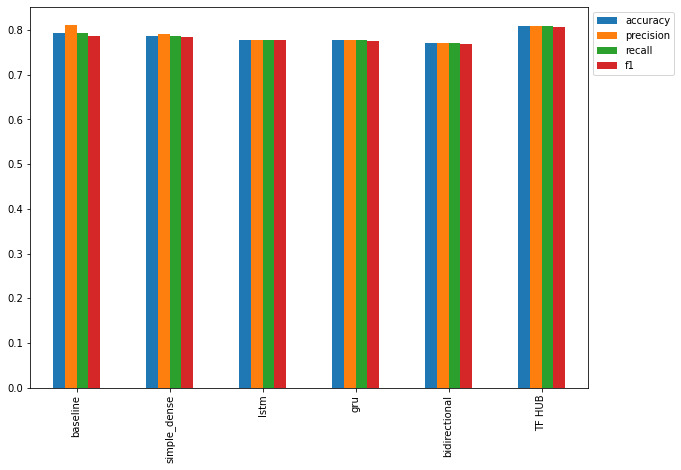

In [ ]:
all_model_results["accuracy"] = all_model_results["accuracy"]/100
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

In [ ]:
!tensorboard dev upload --logdir /content/model_logs/ \
    --name "NLP Models" \
    --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

/content/model_logs/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=SJuPfxZmK5vESjZ7CpB72Wf9JDoVhN&prompt=consent&access_type=

In [ ]:
!tensorboard dev list

https://tensorboard.dev/experiment/s8gqJvOdQq6EaOrG7hVgKw/
	Name                 NLP Models
	Description          [No Description]
	Id                   s8gqJvOdQq6EaOrG7hVgKw
	Created              2022-02-11 14:42:41 (18 seconds ago)
	Updated              2022-02-11 14:42:46 (13 seconds ago)
	Runs                 10
	Tags                 5
	Scalars              150
	Tensor bytes         0
	Binary object bytes  2069594
https://tensorboard.dev/experiment/RbntdcZpQDO0K9dz2m9bVw/
	Name                 NLP Models
	Description          [No Description]
	Id                   RbntdcZpQDO0K9dz2m9bVw
	Created              2022-02-11 13:40:03 (1 hour ago)
	Updated              2022-02-11 13:40:10 (1 hour ago)
	Runs                 10
	Tags                 5
	Scalars              150
	Tensor bytes         0
	Binary object bytes  2069583
Total: 2 experiment(s)


# Finding the most wrong example

In [ ]:
model_5

In [ ]:
# Make Predictions with the loaded model
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:5]

array([[0.17583707],
       [0.7890006 ],
       [0.9914643 ],
       [0.22730424],
       [0.74461615]], dtype=float32)

In [ ]:
model_5_pred_probs.shape

(762, 1)

In [ ]:
model_5_pred = tf.squeeze(tf.round(model_5_pred_probs))
model_5_pred[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 1., 1., 0., 1.], dtype=float32)>

In [ ]:
val_df = pd.DataFrame({'text': val_sentences,
                       'target':val_labels,
                       'preds':model_5_preds.numpy().astype('int64'),
                       'probability':tf.squeeze(model_5_pred_probs)})
val_df.head()

,text,target,preds,probability
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0,0.175837
1,FedEx no longer to transport bioterror germs i...,0,1,0.789001
2,Gunmen kill four in El Salvador bus attack: Su...,1,1,0.991464
3,@camilacabello97 Internally and externally scr...,1,0,0.227304
4,Radiation emergency #preparedness starts with ...,1,1,0.744616


In [ ]:
most_wrong = val_df[val_df['target']!=val_df['preds']].sort_values('probability',ascending=False)
most_wrong[:10] #False Positives

,text,target,preds,probability
31,? High Skies - Burning Buildings ? http://t.co...,0,1,0.938800
628,@noah_anyname That's where the concentration c...,0,1,0.904540
759,FedEx will no longer transport bioterror patho...,0,1,0.903340
393,@SonofLiberty357 all illuminated by the bright...,0,1,0.870128
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1,0.841784
49,@madonnamking RSPCA site multiple 7 story high...,0,1,0.838318
144,The Sound of Arson,0,1,0.837449
381,Deaths 3 http://t.co/nApviyGKYK,0,1,0.806011
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1,0.805244
251,@AshGhebranious civil rights continued in the ...,0,1,0.801041


In [ ]:
most_wrong.tail() #False negative(Predicting negative class but it should be positive)

,text,target,preds,probability
233,I get to smoke my shit in peace,1,0,0.055389
38,Why are you deluged with low self-image? Take ...,1,0,0.051328
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0,0.045900
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0,0.042523
23,Ron &amp; Fez - Dave's High School Crush https...,1,0,0.041698


In [ ]:
for row in most_wrong[:10].itertuples():
    _, text, target, pred, prob = row
    print(f"Target: {target}, Pred: {pred}, Prob: {prob}")
    print(f"Text : \n{text}\n")
    print("*"*100)

Target: 0, Pred: 1, Prob: 0.9388003349304199
Text : 
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

****************************************************************************************************
Target: 0, Pred: 1, Prob: 0.9045400023460388
Text : 
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

****************************************************************************************************
Target: 0, Pred: 1, Prob: 0.9033403396606445
Text : 
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

****************************************************************************************************
Target: 0, Pred: 1, Prob: 0.870128333568573
Text : 
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

****************************************************************************************************
Target: 0, Pred: 

In [ ]:
for row in most_wrong[-10:].itertuples():
    _, text, target, pred, prob = row
    print(f"Target: {target}, Pred: {pred}, Prob: {prob}")
    print(f"Text : \n{text}\n")
    print("*"*100)

Target: 1, Pred: 0, Prob: 0.0651465654373169
Text : 
going to redo my nails and watch behind the scenes of desolation of smaug ayyy

****************************************************************************************************
Target: 1, Pred: 0, Prob: 0.06477285176515579
Text : 
@DavidVonderhaar At least you were sincere ??

****************************************************************************************************
Target: 1, Pred: 0, Prob: 0.06180302053689957
Text : 
Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

****************************************************************************************************
Target: 1, Pred: 0, Prob: 0.059320300817489624
Text : 
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

****************************************************************************************************
Target: 1